# I. Algorithm

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches

In [136]:
def build_adj(data):
    '''
    Given a data matrix that contains the edges that connect vertices, this function builds the adjacency matrix that connects edges, this is for undirected graphs
    '''
    vertices = np.max(data) # Max Vertex Number
    adj = np.zeros((vertices+1, vertices+1)) # Initializing adjacency matrix
    for i in range(0,len(data)):
        adj[int(data[i,0]),int(data[i,1])] = 1
        adj[int(data[i,1]),int(data[i,0])] = 1
    return adj  

def label_propagation(adj):
    '''
    Given an adjacency matrix, assigns labels to each vertex using the label propagation algorithm
    '''
    vertices = len(adj)  # number of vertices
    labels = np.arange(vertices)  # initialize each vertex's label to its own index
    iterations = 0 # Iterations counter

    while True:
        
        updated = False  # flag to check if any label changed

        for i in range(vertices):
            # Find neighbors
            neighbors = np.where(adj[i] == 1)[0] 
            if len(neighbors) == 0:
                continue  # if no neighbors, skip

            neighbor_labels = labels[neighbors]

            # Find most common neighbor label (randomly breaking ties)
            unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
            max_count_labels = unique_labels[counts == counts.max()]
            most_common_label = np.random.choice(max_count_labels)

            # Update label if it changes
            if labels[i] != most_common_label:
                labels[i] = most_common_label
                updated = True

        if not updated or iterations > 100:
            break  # if no label changed during full pass, algorithm is done

        iterations = iterations + 1 # Update iteration counter
    return labels, iterations

def plot_label_prop(adj, labels, iteration):
    '''
    Plotting graph with colors given adj, labels (numpy vector that gives labels of vertices) and number of iterations
    '''
    graph = nx.Graph(adj)

    # Find all unique cluster labels
    unique_clusters = np.unique(labels)

    # Create a color map
    cmap = plt.cm.Set3
    colors = cmap(np.linspace(0, 1, len(unique_clusters)))

    # Draw nodes
    plt.figure(figsize=(7,5))
    pos = nx.spring_layout(graph, seed=42)

    # Getting color list
    node_color_list = [colors[np.where(unique_clusters == label)[0][0]] for label in labels]

    nx.draw(
        graph,
        pos,
        node_color=node_color_list,
        with_labels=False,
        node_size=100,
        edge_color='gray'
    )

    plt.title(f'Graph Colored by Label Propagation After {iteration} Iterations')

    # Create legend
    patches = []
    for idx, cluster in enumerate(unique_clusters):
        patch = mpatches.Patch(color=colors[idx], label=f'Cluster {cluster}')
        patches.append(patch)

    plt.legend(handles=patches, loc='best', title='Clusters', fontsize='small')

    plt.show()


# II. Application to Data Set

We will load in our data and restrict our data to the top 400 vertices only. This is because our data set is way too large and we would not be able to successfully visualize all of the vertices.

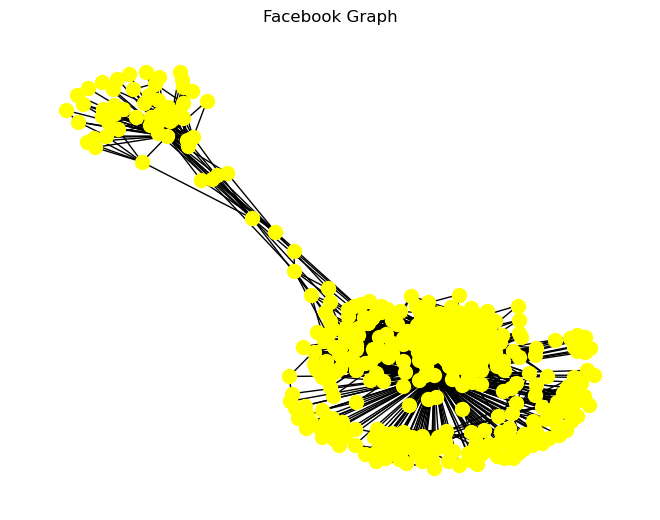

In [137]:
# Loading in Data Set of Facebook Data 
edges = pd.read_csv('facebook_combined.txt', sep=' ', header=None)
edges.columns = ['source', 'target']

# Restrict: Only vertices 0 to 400
edges_restricted = edges[(edges['source'] <= 400) & (edges['target'] <= 400)]

facebook_adj = build_adj(edges_restricted.to_numpy())

facebook = nx.Graph(facebook_adj)
nx.draw(facebook, with_labels = False, node_color= 'yellow', node_size = 100)
plt.title('Facebook Graph')
plt.show()


We can clearly see 2 main clusters of vertices. Let's plot a histogram to see the distribution of the number of neighbors each vertex has.

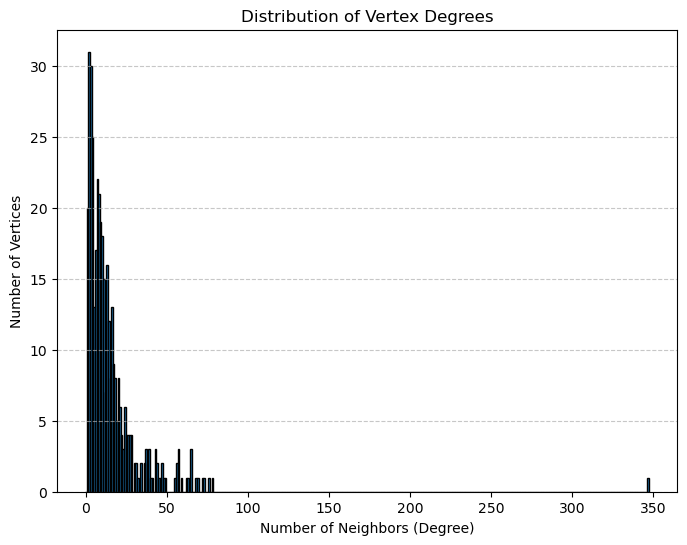

In [138]:
# Compute degree of each vertex
degrees = np.sum(facebook_adj, axis=1)

# Plot histogram
plt.figure(figsize=(8,6))
plt.hist(degrees, bins=range(int(degrees.max()) + 2), edgecolor='black', align='left')
plt.xlabel('Number of Neighbors (Degree)')
plt.ylabel('Number of Vertices')
plt.title('Distribution of Vertex Degrees')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

This distribution is extremeley right skewed with one huge outlier. Most vertices only have a couple neighbors but one is at the center of the cluster and has almost 350 neighbors. Now, let's apply label propagation to see the clusters formed.

Number of clusters in our Facebook Network: 9
Cluster 5: 13 nodes
Cluster 25: 237 nodes
Cluster 195: 10 nodes
Cluster 214: 34 nodes
Cluster 219: 8 nodes
Cluster 263: 15 nodes
Cluster 299: 21 nodes
Cluster 320: 13 nodes
Cluster 366: 50 nodes


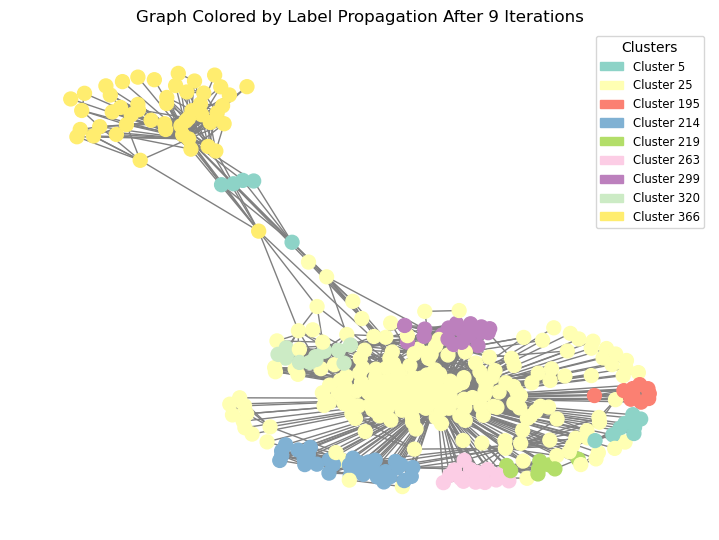

In [139]:
facebook_labels, final_iterations = label_propagation(facebook_adj)

# Getting number of clusters
num_clusters = len(np.unique(facebook_labels))
print(f"Number of clusters in our Facebook Network: {num_clusters}")

# Getting size of each cluster

unique_labels, counts = np.unique(facebook_labels, return_counts=True)

for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} nodes")


# Plotting Final
plot_label_prop(facebook_adj, facebook_labels, final_iterations)

After 9 iterations of our algorithm, we can see there are 8 clusters with one huge cluster and 7 smaller clusters. We can see that within the 2 large groups of data actually lie smaller clusters of data around the edges. 